In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

from keras_transfer_learning.utils import visualize

Using TensorFlow backend.


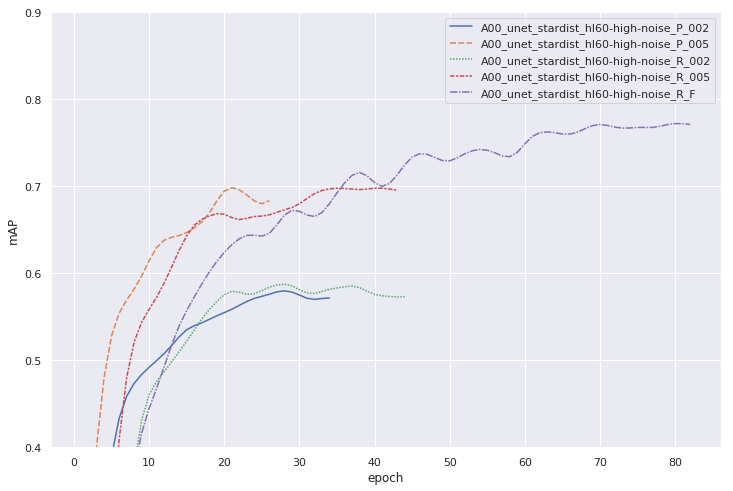

In [2]:
fig = visualize.plot_map_over_epoch('A00_.*_hl60-high-noise.*_(002|005|F)')
# fig.savefig('/tmp/test.pdf')

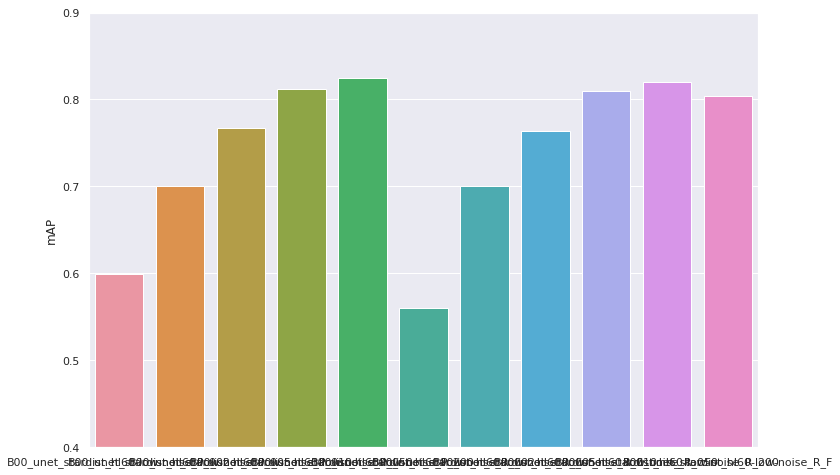

In [3]:
fig = visualize.plot_map_last('B00_.*_hl60')

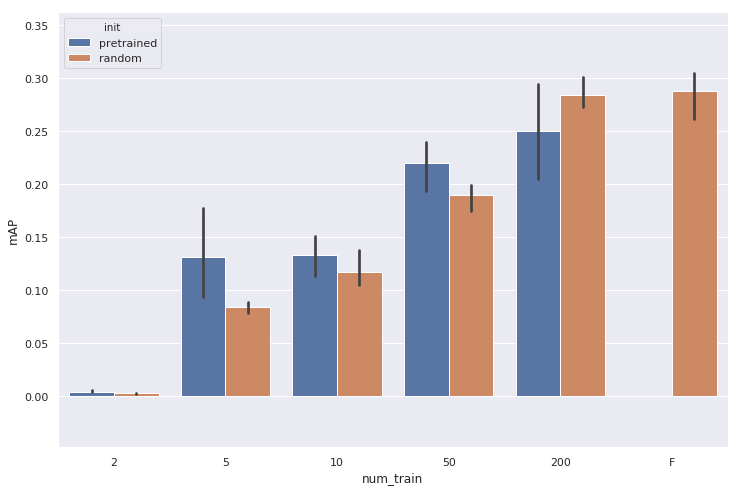

In [4]:
fig = visualize.plot_map_last_compare('C[0-9][0-9]_.*_dsb2018')